In [69]:
!wget --no-check-certificate https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip -O /tmp/rockpaperscissors.zip

--2020-05-27 14:47:54--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M  27.4MB/s    in 11s     

2020-05-27 14:48:05 (28.7 MB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]



In [119]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Sequential
from tensorflow.keras.models import Model
import tensorflow as tf
import os
import shutil
import random
import zipfile


def tf_data_generator(generator, input_shape):
    num_class = generator.num_classes
    tf_generator = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None
                        , input_shape[0]
                        , input_shape[1]
                        , input_shape[2]]
                       ,[None, num_class])
    )
    return tf_generator

# zip extract
local_zip = '/tmp/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

source_dir = '/tmp/rockpaperscissors/'

# initiate files list

rock_files = os.listdir(source_dir+'rock')
paper_files = os.listdir(source_dir+'paper')
scissors_files = os.listdir(source_dir+'scissors')

# val files threshold
val_threshold = 0.3
rock_val_th = round(len(rock_files) * val_threshold)
paper_val_th = round(len(rock_files) * val_threshold)
scissors_val_th = round(len(rock_files) * val_threshold)

# create rps_dataset directory
val_dir = 'tmp/rps_dataset/val/'
if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)
os.makedirs(val_dir+'rock')
os.makedirs(val_dir+'paper')
os.makedirs(val_dir+'scissors')

train_dir = 'tmp/rps_dataset/train/'
if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)
os.makedirs(train_dir+'rock')
os.makedirs(train_dir+'paper')
os.makedirs(train_dir+'scissors')

# move random validation files from datasource to dataset directory
rock_to_move = [rock_files.pop(random.randrange(0, len(rock_files))) for _ in range(rock_val_th)]
for file_to_move in rock_to_move:
  path = os.path.join(source_dir+'rock', file_to_move)
  shutil.move(path, val_dir+'rock')

paper_to_move = [paper_files.pop(random.randrange(0, len(paper_files))) for _ in range(paper_val_th)]
for file_to_move in paper_to_move:
  path = os.path.join(source_dir+'paper', file_to_move)
  shutil.move(path, val_dir+'paper')

scissors_to_move = [scissors_files.pop(random.randrange(0, len(scissors_files))) for _ in range(scissors_val_th)]
for file_to_move in scissors_to_move:
  path = os.path.join(source_dir+'scissors', file_to_move)
  shutil.move(path, val_dir+'scissors')

# refresh rest of files list after move validation files

rock_files = os.listdir(source_dir+'rock')
paper_files = os.listdir(source_dir+'paper')
scissors_files = os.listdir(source_dir+'scissors')

# move train files from datasource to dataset directory
for file_to_move in rock_files:
  path = os.path.join(source_dir+'rock', file_to_move)
  shutil.move(path, train_dir+'rock')

for file_to_move in paper_files:
  path = os.path.join(source_dir+'paper', file_to_move)
  shutil.move(path, train_dir+'paper')

for file_to_move in scissors_files:
  path = os.path.join(source_dir+'scissors', file_to_move)
  shutil.move(path, train_dir+'scissors')


# Input Params for network
dim = (150, 150)
channel = (3, )
input_shape = dim + channel
batch_size = 16

# Augmentation
train_datagen = ImageDataGenerator(
                    rescale=1./255,        
                    horizontal_flip=True,
                    vertical_flip = True,
                    height_shift_range=0.2,
                    validation_split = 0.2
                    )

val_datagen = ImageDataGenerator(rescale=1./255)

# generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=dim,  
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        val_dir, 
        target_size=dim, 
        batch_size=batch_size,
        class_mode='categorical')

num_class = train_generator.num_classes

# Transform data generator to tf.data
train_data = tf_data_generator(train_generator, input_shape)
val_data = tf_data_generator(validation_generator, input_shape)



Found 1534 images belonging to 3 classes.
Found 654 images belonging to 3 classes.


In [120]:
# Model Structure
tf.keras.backend.clear_session()

model = Sequential()
model.add(layers.Conv2D(32, (1, 1), strides=2, input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.DepthwiseConv2D((1,1)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(1024))
model.add(layers.Activation('relu'))

model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_class))
model.add(layers.Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 75, 75, 32)        128       
_________________________________________________________________
batch_normalization (BatchNo (None, 75, 75, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 75, 75, 32)        0         
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 75, 75, 32)        64        
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 73, 73, 64)        1

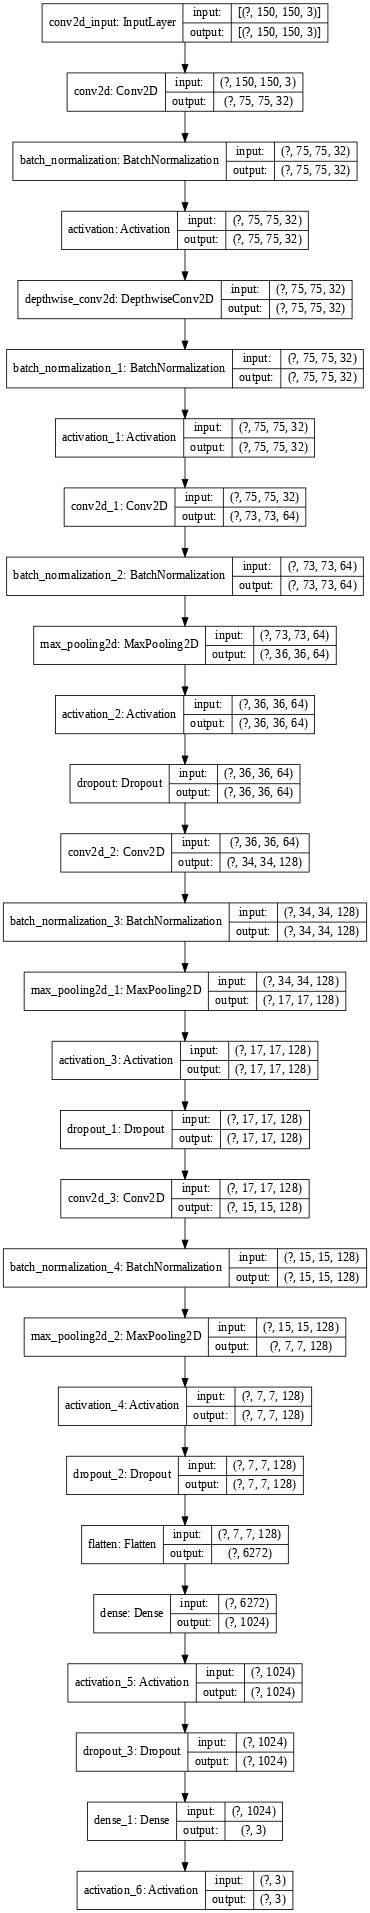

In [121]:
model_viz = tf.keras.utils.plot_model(model,
                          to_file='model_viz.png',
                          show_shapes=True,
                          show_layer_names=True,
                          rankdir='TB',
                          expand_nested=True,
                          dpi=60)
model_viz

In [122]:
# Set randoom seed for same samples in each training iteration
from numpy.random import seed
seed(2)
tf.random.set_seed(2)

# Model Training
filepath="rps_mfr_best_model.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5)

history = model.fit(x=train_data,
        steps_per_epoch= len(train_generator),
        epochs=15,
        validation_data=val_data,
        validation_steps= len(validation_generator),
        callbacks=[checkpoint, early_stop],
        verbose = 1)


Epoch 1/15
96/96 [==============================] - ETA: 0s - loss: 5.2526 - accuracy: 0.5130
Epoch 00001: val_accuracy improved from -inf to 0.33333, saving model to rps_mfr_best_model.h5
96/96 [==============================] - 97s 1s/step - loss: 5.2526 - accuracy: 0.5130 - val_loss: 2.5114 - val_accuracy: 0.3333
Epoch 2/15
96/96 [==============================] - ETA: 0s - loss: 0.8827 - accuracy: 0.7842
Epoch 00002: val_accuracy did not improve from 0.33333
96/96 [==============================] - 96s 1000ms/step - loss: 0.8827 - accuracy: 0.7842 - val_loss: 2.1356 - val_accuracy: 0.3287
Epoch 3/15
96/96 [==============================] - ETA: 0s - loss: 0.3573 - accuracy: 0.9022
Epoch 00003: val_accuracy did not improve from 0.33333
96/96 [==============================] - 96s 998ms/step - loss: 0.3573 - accuracy: 0.9022 - val_loss: 3.5531 - val_accuracy: 0.3333
Epoch 4/15
96/96 [==============================] - ETA: 0s - loss: 0.2963 - accuracy: 0.9192
Epoch 00004: val_accuracy

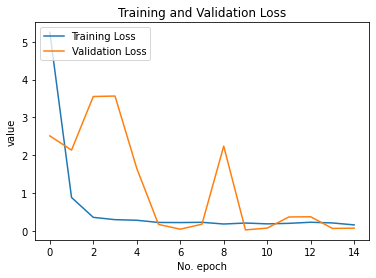

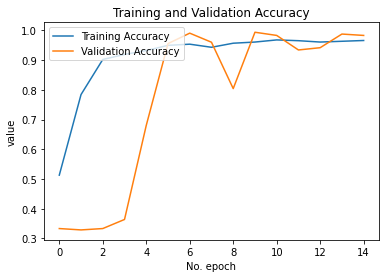

In [123]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [124]:
# Best model from previous training reload
model.load_weights("rps_mfr_best_model.h5")
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

print(model.get_weights())

[array([[[[-0.31464088, -0.01701589, -0.22653803, -0.16342871,
           0.39400735,  0.4221476 ,  0.0743405 , -0.3317649 ,
           0.3998653 ,  0.18945968,  0.4009111 ,  0.23367508,
           0.2840547 , -0.01786797, -0.13957803,  0.17594457,
           0.15237834, -0.31015322, -0.1087337 , -0.3980909 ,
           0.36683327, -0.33592343, -0.11224387, -0.3005847 ,
           0.35356346,  0.10223177,  0.32110804,  0.20506057,
           0.14071515,  0.12909272, -0.34088895,  0.24075   ],
         [-0.03527358,  0.12323698, -0.179755  ,  0.28771037,
           0.14754187, -0.13316058,  0.3165748 , -0.16487333,
           0.39812222,  0.1596609 , -0.07496228,  0.35951847,
          -0.33702168,  0.40929982,  0.25271782, -0.08173274,
           0.28835535,  0.29178572, -0.29425338,  0.10221863,
          -0.38107008,  0.32432747,  0.21863483,  0.1878228 ,
           0.11615163, -0.01874417, -0.3904267 ,  0.35600057,
           0.21592996, -0.337057  , -0.22705951,  0.25543925],
     

Saving batu_1.jpeg to batu_1 (7).jpeg
Saving batu_2.jpeg to batu_2 (7).jpeg
Saving batu_3.jpeg to batu_3 (7).jpeg
Saving batu_4.jpeg to batu_4 (7).jpeg
Saving batu_5.jpeg to batu_5 (7).jpeg
batu_1.jpeg
rock 1.0
batu_2.jpeg
rock 1.0
batu_3.jpeg
paper 0.99999464
batu_4.jpeg
rock 1.0
batu_5.jpeg
rock 1.0


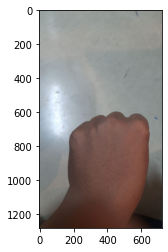

In [129]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

def preprocess(img,input_size):
    nimg = img.convert('RGB').resize(input_size, resample= 0)
    img_arr = (np.array(nimg))/255
    return img_arr
def reshape(imgs_arr):
    return np.stack(imgs_arr, axis=0)

#define labels
labels = ['paper', 'rock', 'scissors']

uploaded = files.upload()

for fn in uploaded.keys():
  img = image.load_img(fn)
  x = preprocess(img,dim)
  x = reshape([x])
  y = model.predict(x)

  print(fn)
  print( labels[np.argmax(y)], np.max(y) )
  imgplot = plt.imshow(img)